In [1]:
from astropy.io import ascii
import matplotlib.tri as tri
import numpy as np
import pandas as pd
from astropy.io import fits
from glob import glob
from joblib import Parallel, delayed
from multiprocessing import  Pool
from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit
# Import
from pandarallel import pandarallel
from scipy.interpolate import interp1d
# Initialization
pandarallel.initialize(nb_workers=22)

INFO: Pandarallel will run on 22 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
MZP_dict =  {'F336W': 29.957853313961245,
             'F438W': 31.42651377146319,
             'F555W': 32.255382407409776,
             'F814W': 31.59792231188404,
             'F656N': 27.714038452114817}

In [3]:
# Import Master Catalogue
df_master = ascii.read('../30Dor_KS2/data/MASTER_CATALOG/LOGR.XYVIQ1').to_pandas()
def give_names(df_master):# Get readable column names
    colnames = df_master.shape[1]*['']
    colnames[0] = 'X'
    colnames[1] = 'Y'
    colnames[2] = 'col3'
    colnames[3] = 'col4'
    filters = ['F555W','F814W','F438W','F336W','F656N']
    for i,filt in enumerate(filters):
        colnames[4+i*6] = 'flux_'+filt
        colnames[5+i*6] = 'rms_'+filt
        colnames[6+i*6] = 'Q_'+filt
        colnames[7+i*6] = 'crowd_'+filt
        colnames[8+i*6] = 'nEXPexp_'+filt
        colnames[9+i*6] = 'nEXPfound_'+filt
    return colnames
df_master.columns = give_names(df_master)
df_master = df_master.sort_values(by=['X','Y'])
df_master['ID'] = np.arange(1,len(df_master)+1)
df_master = df_master.set_index('ID')
df_master.head(4)

# Assign instrumental magnitudes (uncalibrated)
# Get magnitudes
filters= ['F336W','F438W','F555W','F814W','F656N']
for i,filt in enumerate(filters):
    df_master['instr_m_'+filt] = -2.5*np.log10(df_master['flux_'+filt])
    
filters= ['F336W','F438W','F555W','F814W','F656N']
for i,filt in enumerate(filters):
    df_master['em_'+filt] = 1.1 * (df_master['rms_'+filt]/df_master['flux_'+filt])
    
# Get the time resolved catalogue
# Match on positions
def get_XY_to_ID():
    XY2ID = df_master.X.round(1).astype(str) + '_' + df_master.Y.round(1).astype(str)
    XY2ID = pd.DataFrame(XY2ID)
    XY2ID = XY2ID.reset_index()
    XY2ID.columns = ['ID','str']
    XY2ID = XY2ID.set_index('str')
    return XY2ID
XY2ID = get_XY_to_ID()
XY2ID.head(3)

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID
str,
16.2_677.0,1
16.5_3016.6,2
16.7_825.4,3


In [26]:
input_Ha = ascii.read('./Halpha/ib6wd1rrq/LOGA.INPUT',fast_reader={'parallel': True, 'use_fast_converter': True}).to_pandas()
input_B  = ascii.read('./Bband/ib6wd1rxq/LOGA.INPUT', fast_reader={'parallel': True, 'use_fast_converter': True}).to_pandas()

In [33]:
input_Ha['ID'] = 'Ha_'+input_Ha['col18']
input_Ha = input_Ha.set_index('ID').iloc[:,:3]

In [ ]:
input_B['ID'] = 'B_'+input_B['col18']
input_B = input_B.set_index('ID').iloc[:,:3]

In [ ]:
input_ = pd.concat((input_B,input_Ha))
input_.columns = ['X','Y','input_mag']

In [54]:
input_['simulated_mag'] = input_.input_mag + pd.Series(input_.index).apply(lambda x: MZP_dict['F438W'] if x.startswith('B') else MZP_dict['F656N']).values

In [39]:
from joblib import Parallel, delayed
obstable= pd.read_csv('../30Dor_KS2/obstable.csv').set_index('OBSERVATION_ID')

def reader(f):
    df = ascii.read(f).to_pandas()
    df.columns = ['X','Y','col3','col4','flux','rms','Q','Crowd','nEXPexp','nEXPfound']
    df = df[df.Q>=0.01]
    df = df[~(df['flux']=='*************')]
    df.flux = df.flux.astype(float)
    df = df[df.flux>0]
    
    exp_name = f.split('/')[2]
    filter_ = obstable.loc[exp_name]['FILTER']
    obstime = obstable.loc[exp_name]['START_TIME']
    exptime = obstable.loc[exp_name]['EXPOSURE_DURATION']

    df['Filter'] = filter_
    if filter_ == 'F438W':
        df['ID'] = 'B_'+df.col4
    elif filter_ == 'F656N':
        df['ID'] = 'Ha_'+df.col4
    df['ObsStart'] = obstime
    
    df['ExpTime'] = exptime
    df['OBS_ID'] = exp_name
    df['mag'] = -2.5*np.log10(df.flux) + MZP_dict[filter_]
    df['emagP'] = 1.1 * np.sqrt(df.flux)/df.flux
    
    df = df[['OBS_ID','Filter','ObsStart','ExpTime','X','Y','flux','Q','Crowd','ID','mag','emagP']]
    return df

def build_time_resolved_df():
    # Now get catalogue of all individual exposures
    flist = glob('./*/*/*.XYVIQ2')
    expnames = [w.split('/')[2] for w in flist]
    
    df_phot = pd.DataFrame({'OBS_ID':[],'Filter':[],'ObsStart':[],'ExpTime':[],'X':[],'Y':[],
                        'flux':[],'Q':[],'Crowd':[], 'ID':[], 'mag':[], 'emagP':[]})
    
    photlist = Parallel(n_jobs=22)(delayed(reader)(f) for f in flist)
    df_phot = pd.concat(photlist)
    df_phot = df_phot.dropna().set_index(['ID','Filter']).sort_index()
    
    df_phot['EpochNR'] = df_phot.OBS_ID.apply(lambda x: x[-4])
    print('Converting to datetimes')
    df_phot['ObsStart'] = pd.to_datetime(df_phot.ObsStart)
    print('Converting to Juliandates')
    df_phot['JulianDate'] = df_phot.ObsStart.parallel_apply(lambda x:x.to_julian_date())
    return df_phot

In [ ]:
# With Artificial stars
df_phot_wA = build_time_resolved_df()

In [69]:
df_phot_wA

OBS_ID                ObsStart  ExpTime      X_x  \
ID          Filter                                                        
B_A0000001  F438W   ib6wd1smq 2009-10-20 08:13:37.000    440.0  1084.88   
            F438W   ib6wd1rxq 2009-10-20 06:51:46.000    440.0  1084.88   
B_A0000004  F438W   ib6wd1smq 2009-10-20 08:13:37.000    440.0  1143.63   
            F438W   ib6wd1rxq 2009-10-20 06:51:46.000    440.0  1143.63   
B_A0000007  F438W   ib6wd1smq 2009-10-20 08:13:37.000    440.0  1322.76   
...                       ...                     ...      ...      ...   
Ha_A0999987 F656N   ib6wd3fdq 2009-10-25 15:15:30.840   1345.0   615.03   
            F656N   ib6wd1rrq 2009-10-20 06:27:25.833   1345.0   615.03   
Ha_A0999988 F656N   ib6wd1rrq 2009-10-20 06:27:25.833   1345.0  1286.15   
Ha_A0999994 F656N   ib6wd3fdq 2009-10-25 15:15:30.840   1345.0  1066.33   
            F656N   ib6wd1rrq 2009-10-20 06:27:25.833   1345.0  1066.33   

                        Y_x          flux      Q   Crowd        mag     emagP  \
ID          Filter                                                              
B_A0000001  F438W   1572.05  6.937175e+04  0.974   51.05  19.323557  0.004176   
            F438W   1572.05  6.585034e+04  0.977   56.33  19.380119  0.004287   
B_A0000004  F438W   1888.92  5.177300e+03  0.601    1.19  22.141255  0.015288   
            F438W   1888.92  5.940011e+03  0.585    1.59  21.992046  0.014272   
B_A0000007  F438W   1708.17  1.344692e+07  0.279    0.00  13.604957  0.000300   
...                     ...           ...    ...     ...        ...       ...   
Ha_A0999987 F656N   1966.98  8.677796e+04  0.584  214.63  15.368015  0.003734   
            F656N   1966.98  1.953519e+05  0.622  844.62  14.486994  0.002489   
Ha_A0999988 F656N   2164.52  8.395458e+03  0.249    0.44  17.903927  0.012005   
Ha_A0999994 F656N   1640.33  8.906102e+04  0.462    0.00  15.339819  0.003686   
            F656N   1640.33  8.175225e+04  0.211    0.00  15.432789  0.003847   

                   EpochNR    JulianDate       X_y       Y_y  input_mag  \
ID          Filter                                                        
B_A0000001  F438W        1  2.455125e+06  1088.083  1575.734    -11.106   
            F438W        1  2.455125e+06  1088.083  1575.734    -11.106   
B_A0000004  F438W        1  2.455125e+06  1145.270  1884.089    -12.467   
            F438W        1  2.455125e+06  1145.270  1884.089    -12.467   
B_A0000007  F438W        1  2.455125e+06  1329.795  1706.670    -24.873   
...                    ...           ...       ...       ...        ...   
Ha_A0999987 F656N        3  2.455130e+06   616.597  1960.576    -17.683   
            F656N        1  2.455125e+06   616.597  1960.576    -17.683   
Ha_A0999988 F656N        1  2.455125e+06  1285.913  2167.768    -11.428   
Ha_A0999994 F656N        3  2.455130e+06  1071.498  1642.471    -17.728   
            F656N        1  2.455125e+06  1071.498  1642.471    -17.728   

                    simulated_mag  
ID          Filter                 
B_A0000001  F438W       20.320514  
            F438W       20.320514  
B_A0000004  F438W       18.959514  
            F438W       18.959514  
B_A0000007  F438W        6.553514  
...                           ...  
Ha_A0999987 F656N       10.031038  
            F656N       10.031038  
Ha_A0999988 F656N       16.286038  
Ha_A0999994 F656N        9.986038  
            F656N        9.986038  

[860910 rows x 16 columns]

In [ ]:
df_phot_wA = pd.merge(df_phot_wA,input_,left_index=True,right_index=True)

In [166]:
a = df_phot_wA[df_phot_wA.Q>0.9]
a=a[a.index.get_level_values(1)=='F438W']
a=a[a.Crowd==0]

In [167]:
a=a.groupby('ID')[['mag','simulated_mag']].agg(['median','std'])

In [169]:
a=a[a.mag['std']<0.07]

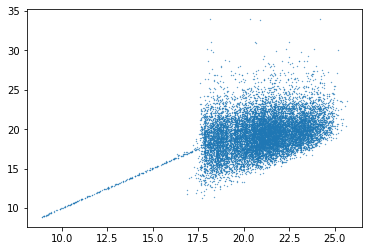

In [170]:
plt.scatter(a.mag['median'],a.simulated_mag['median'],s=0.1)

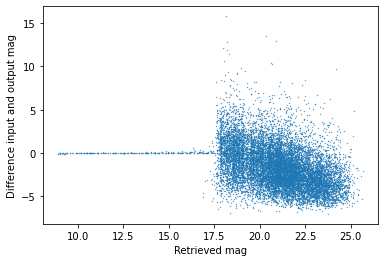

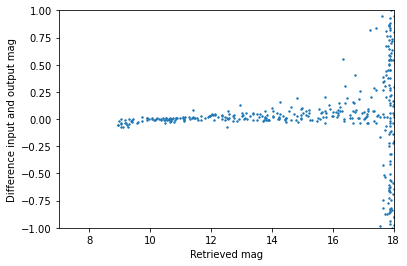

In [177]:
plt.scatter(a.mag['median'],a.simulated_mag['median']-a.mag['median'],s=0.1)
plt.xlabel('Retrieved mag')
plt.ylabel('Difference input and output mag')
plt.show()

plt.scatter(a.mag['median'],a.simulated_mag['median']-a.mag['median'],s=2)
plt.xlabel('Retrieved mag')
plt.ylabel('Difference input and output mag')
plt.xlim(7,18)
plt.ylim(-1,1)
plt.show()


Text(0, 0.5, 'Difference input and output mag')

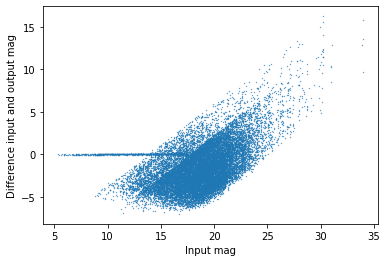

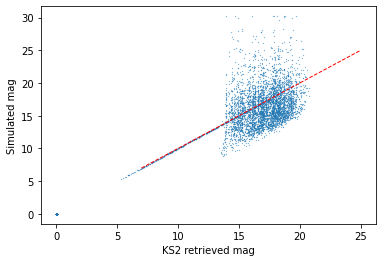

In [141]:
a.plot.scatter(x='mag',y='simulated_mag',s=0.05)
plt.xlabel('KS2 retrieved mag')
plt.ylabel('Simulated mag')
plt.plot([7,25],[7,25],c='red',ls='--',lw=1)

Converting to datetimes
Converting to Juliandates


In [ ]:
# Without Artificial stars
df_phot_noA = pd.read_pickle('../30Dor_KS2/KS2_timeresolved.pickle')

In [9]:
df = df_phot_noA[df_phot_noA.OBS_ID==df_phot_wA.OBS_ID.unique()[0]]
for i in range(1,4):
    df = pd.concat((df,df_phot_noA[df_phot_noA.OBS_ID==df_phot_wA.OBS_ID.unique()[i]]))
df_phot_noA = df.sort_index()

In [10]:
df_phot_noA['unique_identifier'] = df_phot_noA[['X','Y','OBS_ID']].astype(str).sum(axis=1).values
df_phot_wA['unique_identifier']  = df_phot_wA[['X','Y','OBS_ID']].astype(str).sum(axis=1).values

In [11]:
merged = pd.merge(df_phot_wA,df_phot_noA,left_on='unique_identifier',right_on='unique_identifier',how='inner')
true_star_uid = merged['unique_identifier'].unique()

In [12]:
df_phot_wA['Artificial'] = df_phot_wA.unique_identifier.parallel_apply(lambda x: x not in true_star_uid)

In [13]:
df_artificial = df_phot_wA[df_phot_wA.Artificial]

In [14]:
twomeas = pd.Series(df_artificial.sort_index().index.get_level_values(0)).value_counts()
df_artificial = df_artificial.loc[twomeas.index[twomeas==2]]

In [15]:
df_artificial.reset_index().set_index('unique_identifier').sort_index()

,ID,Filter,OBS_ID,ObsStart,ExpTime,X,Y,flux,Q,Crowd,mag,emagP,EpochNR,JulianDate,Artificial
unique_identifier,,,,,,,,,,,,,,,
100.622075.22ib6wd1rrq,Ha516240,F656N,ib6wd1rrq,2009-10-20 06:27:25.833,1345.0,100.62,2075.22,3.403505e+03,0.311,0.00,18.884222,0.018855,1,2.455125e+06,True
100.622075.22ib6wd1rrq,Ha497873,F656N,ib6wd1rrq,2009-10-20 06:27:25.833,1345.0,100.62,2075.22,2.247820e+02,0.098,0.00,21.834635,0.073369,1,2.455125e+06,True
1000.012332.31ib6wd1rxq,B578335,F438W,ib6wd1rxq,2009-10-20 06:51:46.000,440.0,1000.01,2332.31,2.005156e+04,0.384,3.43,20.671143,0.007768,1,2.455125e+06,True
1000.012332.31ib6wd1rxq,B602518,F438W,ib6wd1rxq,2009-10-20 06:51:46.000,440.0,1000.01,2332.31,1.630200e+02,0.376,1.13,25.895912,0.086153,1,2.455125e+06,True
1000.012332.31ib6wd1smq,B585530,F438W,ib6wd1smq,2009-10-20 08:13:37.000,440.0,1000.01,2332.31,2.475434e+03,0.467,1.72,22.942385,0.022109,1,2.455125e+06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999.342552.78ib6wd1rrq,Ha648251,F656N,ib6wd1rrq,2009-10-20 06:27:25.833,1345.0,999.34,2552.78,2.640698e+07,0.314,0.00,9.159742,0.000214,1,2.455125e+06,True
999.342552.78ib6wd3fdq,Ha669207,F656N,ib6wd3fdq,2009-10-25 15:15:30.840,1345.0,999.34,2552.78,4.548021e+03,0.233,0.00,18.569482,0.016311,3,2.455130e+06,True
999.342552.78ib6wd3fdq,Ha648349,F656N,ib6wd3fdq,2009-10-25 15:15:30.840,1345.0,999.34,2552.78,8.315166e+04,0.651,0.00,15.414361,0.003815,3,2.455130e+06,True


In [16]:
df_artificial[df_artificial.Q>0.9].sort_values(by=['X','Y'])

,,OBS_ID,ObsStart,ExpTime,X,Y,flux,Q,Crowd,mag,emagP,EpochNR,JulianDate,unique_identifier,Artificial
ID,Filter,,,,,,,,,,,,,,
B458088,F438W,ib6wd1rxq,2009-10-20 06:51:46.000,440.0,20.90,1984.04,3.344480e+04,0.948,7890.21,20.115692,0.006015,1,2.455125e+06,20.91984.04ib6wd1rxq,True
Ha290706,F656N,ib6wd1rrq,2009-10-20 06:27:25.833,1345.0,151.07,1662.27,1.840820e+08,0.977,0.00,7.051510,0.000081,1,2.455125e+06,151.071662.27ib6wd1rrq,True
B29441,F438W,ib6wd1smq,2009-10-20 08:13:37.000,440.0,178.21,495.65,1.313210e+04,0.972,1386.93,21.130678,0.009599,1,2.455125e+06,178.21495.65ib6wd1smq,True
Ha254199,F656N,ib6wd3fdq,2009-10-25 15:15:30.840,1345.0,185.24,1557.50,1.303182e+04,0.911,0.00,17.426526,0.009636,3,2.455130e+06,185.241557.5ib6wd3fdq,True
Ha184411,F656N,ib6wd1rrq,2009-10-20 06:27:25.833,1345.0,213.01,1219.03,2.511101e+06,0.962,0.00,11.714378,0.000694,1,2.455125e+06,213.011219.03ib6wd1rrq,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ha405506,F656N,ib6wd3fdq,2009-10-25 15:15:30.840,1345.0,3834.87,1896.32,4.349704e+06,0.965,0.00,11.117889,0.000527,3,2.455130e+06,3834.871896.32ib6wd3fdq,True
Ha406875,F656N,ib6wd1rrq,2009-10-20 06:27:25.833,1345.0,3834.87,1896.32,4.354505e+06,0.965,0.00,11.116691,0.000527,1,2.455125e+06,3834.871896.32ib6wd1rrq,True
Ha192924,F656N,ib6wd1rrq,2009-10-20 06:27:25.833,1345.0,3882.78,1218.69,3.287903e+06,0.937,0.00,11.421741,0.000607,1,2.455125e+06,3882.781218.69ib6wd1rrq,True


In [ ]:
xy=df_artificial[df_artificial.index.get_level_values(1)=='F656N'].reset_index()[['X','Y']]

In [43]:
XY2ID_Ha.reindex(xy.X.round(1).astype(str) + '_' + xy.Y.round(1).astype(str)).values

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])

In [41]:
XY2ID_Ha

,ID
str,
1284.2_1607.5,19934
1832.4_1807.7,603148
3464.1_1302.8,521222
2920.6_2763.5,180028
3727.0_3651.0,41901
...,...
2970.9_3291.6,456750
381.1_3135.1,488073
3463.6_2178.1,215945
